# Imports

In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pickle 
import matplotlib.pyplot as plt

# from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.tree import plot_tree
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
input_files = []

for dirname, _, filenames in os.walk('dataset\CICIDS2017_improved'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        input_files.append(os.path.join(dirname, filename))
        
# print(input_files)
# print("\nImports done")

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset\CICIDS2017_improved\friday.csv
dataset\CICIDS2017_improved\monday.csv
dataset\CICIDS2017_improved\thursday.csv
dataset\CICIDS2017_improved\tuesday.csv
dataset\CICIDS2017_improved\wednesday.csv


# Cleanup for CSECICIDS2018_improved and CICIDS2017_improved

In [49]:
def label_mapper(label):
    # BENIGN, web_attack, ddos, botnet, infiltration, dos, ssh_bruteforce, ftp_bruteforce, others
    if label == 'BENIGN':
        return 0
    elif label.startswith("Web Attack"):
        return 1
    elif label.startswith("DDoS"):
        return 2
    elif label.startswith("Botnet"):
        return 3
    elif label.startswith("Infiltration") or label.startswith("Portscan") :
        return 4
    elif label.startswith("DoS"):
        return 5
    elif label.startswith("SSH"):
        return 6
    elif label.startswith("FTP"):
        return 7
    else:
        return 8


def dataset_cleaner(df):
    # change label
    df['Label'] = df['Label'].apply(label_mapper)
    
    # drop all categorical columns
    categorical_columns = df.select_dtypes(include=['object'])
    df.drop(columns=categorical_columns.columns.values, inplace=True)
    # id is unique for all, CISIAS notebook removed attempted category too
    df.drop(columns=['id', 'Attempted Category'], inplace=True)
    
#     print(df.columns.values)
    
    # drop all inf and other nan values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=0,how='any', inplace=True)
    
    return df

def get_target_features(df, test_size = 0.30):
    X = df.drop(['Label'], axis=1)
    y = df['Label']
    
    return train_test_split(X, y, test_size=test_size, random_state=42)

print("Functions defined")

Functions defined


# Feature Selection

In [50]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

def select_features_correlation(X, y, k=10):
    """
    Select top k features based on correlation with the target.

    Parameters:
    - X: DataFrame, the feature matrix.
    - y: Series, the target variable.
    - k: int, number of top features to select.

    Returns:
    - List of top k features based on correlation.
    """
    # Factorize the target and convert to pandas Series
    y_factorized = pd.Series(y.factorize()[0], index=y.index)
    
    # Convert categorical features to numeric
    X_encoded = X.apply(LabelEncoder().fit_transform)
    
    # Compute correlation
    correlation = X_encoded.corrwith(y_factorized)
    
    # Create a DataFrame for correlation values
    correlation_df = pd.DataFrame({
        'Feature': correlation.index,
        'Correlation': correlation.values
    }).sort_values(by='Correlation', key=abs, ascending=False)
    
    # Select top k features
    return correlation_df.head(k)['Feature'].tolist()

def select_features_information_gain(X, y, k=10):
    """
    Select top k features based on information gain with the target.

    Parameters:
    - X: DataFrame, the feature matrix.
    - y: Series, the target variable.
    - k: int, number of top features to select.

    Returns:
    - List of top k features based on information gain.
    """
    # Convert categorical features to numeric
    X_encoded = X.apply(LabelEncoder().fit_transform)
    
    # Calculate information gain
    info_gain = mutual_info_classif(X_encoded, y, discrete_features='auto', random_state=42)
    
    # Create a DataFrame for information gain values
    info_gain_df = pd.DataFrame({
        'Feature': X.columns,
        'Information Gain': info_gain
    }).sort_values(by='Information Gain', ascending=False)
    
    # Select top k features
    return info_gain_df.head(k)['Feature'].tolist()

def get_top_features_across_files(file_paths, label_column, k=10):
    """
    Get top k features across multiple files, based on both correlation and information gain.

    Parameters:
    - file_paths: list of file paths.
    - label_column: name of the label column.
    - k: number of top features to select.

    Returns:
    - List of top k features consistent across all files.
    """
    feature_counter = Counter()
    idx = 1

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        X = df.drop(columns=[label_column])
        y = df[label_column]
        
        # Select top features using both methods
        top_corr_features = select_features_correlation(X, y, k)
        top_ig_features = select_features_information_gain(X, y, k)
        
        # Combine and count features
        feature_counter.update(top_corr_features + top_ig_features)
        print("File "+str(idx)+" done.")
        idx = idx+1
    
    # Get most common features across files
    most_common_features = feature_counter.most_common(k)
    return [feature for feature, _ in most_common_features]

def remove_selected_features(df, selected_features):
    """
    Remove selected features from the given DataFrame.

    Parameters:
    - df: DataFrame, the input DataFrame.
    - selected_features: list of feature names to be removed.

    Returns:
    - DataFrame with the selected features removed.
    """
    # Drop the selected features
    updated_df = df.drop(columns=selected_features, errors='ignore')
    return updated_df



In [ ]:
top_features = get_top_features_across_files(input_files,'Label',20)
print(top_features)

# Load each file, do label clean up, run random forest  on it

In [ ]:
# we will add to these 3 lists test set and predictions for all csv
# then we will merge them in one pandas object
# then we can do metrics on the dataset as a whole
# pros: will get whole dataset metrics
# cons: the 3 list and merged object may overflow 30 gb ram (praying it wont)
X_test_sets = []
y_test_sets = []

# MODELS
print("Initializing RF model")
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

i = 0

for f in input_files:
    
    i += 1
        
    print(f"{i}/{len(input_files)} CURRENT FILE: {f}\n")
    
    df = pd.read_csv(f)
    
    print(f"LOADED FILE {f}, STARTING CLEANUP\n")
    
    df = dataset_cleaner(df)

    df = remove_selected_features(df,top_features)
    
    print(f"CLEANUP DONE, STARTING SPLIT\n")
    
    X_train, X_test, y_train, y_test = get_target_features(df, 0.30)
    
    # no need for df now
    df = None
    gc.collect()
    
    X_test.to_csv(f"test_chunks/{i}X_test.csv", index=False)
    y_test.to_csv(f"test_chunks/{i}y_test.csv", index=False)
    
    # no need for the test sets either
    del X_test
    del y_test
    gc.collect()
    
    print("DONE WRITING TEST SETS TO FILES, STARTING TRAIN\n")
    
    # rf
    print("RUNNING RF MODEL TRAIN...\n")
    
    rf_model.fit(X_train, y_train)
    
    del X_train
    del y_train
    gc.collect()
    
    print(f"RF MODEL TRAINED ON FILE: {f} \n\n")
    

print(f"{i}/{len(input_files)} files worked on\n\n")

# clear memory
df = None
gc.collect()

# Prepare outputs for metric calculation

In [ ]:
print("READING X TEST SETS AND PREDICTING\n")
gc.collect()

rf_predictions = []
y_tests = []

for curr in range(1,i+1):
    print(f"Reading X_test file {curr}/{i}\n")

    df_X = pd.read_csv(f"test_chunks/{curr}X_test.csv")
    
    print(f"Read {curr}-th X_test file, shape: {df_X.shape}\nPredicting and appending...")
    
    pred = rf_model.predict(df_X)
    rf_predictions.append(pred)
    
    del df_X 
    gc.collect()
    
    print(f"Done reading and predictiong on X_test file {curr}/{i}\n")
    

rf_predictions_joined = np.concatenate(rf_predictions)

# remove prediction list
del rf_predictions
gc.collect()

print("PREDICTION DONE USING RF MODELS: ")
print( rf_predictions_joined.shape)

print("\nREADING y_test FILES\n")

for curr in range(1,i+1):
    print(f"Reading y_test file {curr}/{i}\n")

    df_y = pd.read_csv(f"test_chunks/{curr}y_test.csv")
    
    print(f"Read {curr}-th y_test file, shape: {df_y.shape}\nAppending...")
    
    y_tests.append(df_y)
    
    del df_y
    gc.collect()
    
    print(f"Done reading and adding y_test file {curr}/{i}\n")
    
y_test_sets_joined = pd.concat(y_tests)

# remove y_tests
del y_tests
gc.collect()


print("DONE READING y_test FILES: ")
print(y_test_sets_joined.shape)

# Metrics

In [ ]:
rf_accuracy = accuracy_score(y_test_sets_joined, rf_predictions_joined)
rf_f1 = f1_score(y_test_sets_joined, rf_predictions_joined, average='macro')
rf_precision = precision_score(y_test_sets_joined, rf_predictions_joined, average='macro')
rf_recall = recall_score(y_test_sets_joined, rf_predictions_joined, average='macro')

print("rf METRICS: \n")
print(f"ACCURACY: \t {rf_accuracy:.4f}")
print(f"F1 SCORE: \t {rf_f1:.4f}")
print(f"PRECISION: \t {rf_precision:.4f}")
print(f"RECALL: \t {rf_recall:.4f}")

# Plots

In [ ]:
# Confusion Matrix
classes = ["BENIGN", "Web Attack", "DDoS", "Botnet", "Infiltration", "DoS", "SSH Bruteforce", "FTP Bruteforce", "Others"]
title = "Confusion Matrix for rf Classifier"

cm = confusion_matrix(y_test_sets_joined, rf_predictions_joined)
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(title)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def save_model(model, filename="model.pkl"):
    with open(filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

In [ ]:
def load_model(filename="model.pkl"):
    with open(filename, "rb") as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

In [ ]:
# Save to a pickle file            
save_model(rf_model,"models/rf.pickle")

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Flow ID', 'Src IP', 'Timestamp', 'Protocol', 'FWD Init Win Bytes', 'Bwd Header Length', 'Dst Port', 'Fwd Segment Size Avg', 'Fwd Packet Length Mean', 'Total TCP Flow Time']
Initializing RF model top_feature_count = 10


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8382
F1 SCORE: 	 0.2944
PRECISION: 	 0.2796
RECALL: 	 0.3194


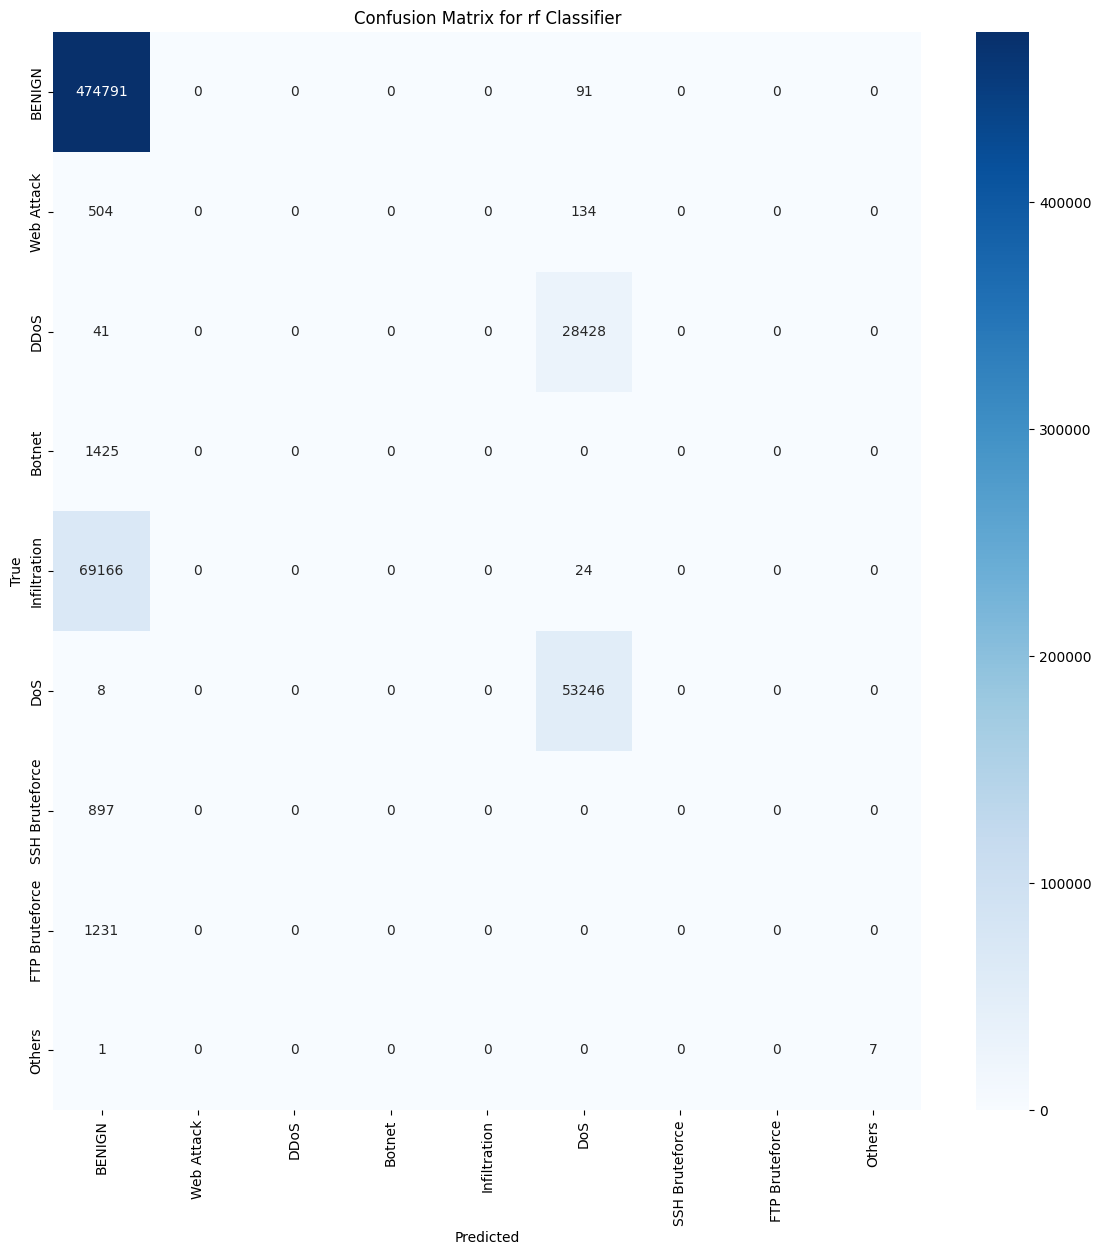

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Flow ID', 'Src IP', 'Fwd Packet Length Mean', 'Fwd Segment Size Avg', 'Protocol', 'Timestamp', 'Bwd Packet Length Max', 'Dst Port', 'FWD Init Win Bytes', 'SYN Flag Count', 'Packet Length Max', 'Bwd Segment Size Avg', 'Fwd Seg Size Min', 'Bwd Header Length', 'Packet Length Mean', 'Average Packet Size', 'Total Length of Bwd Packet', 'Bwd Packet Length Mean', 'Fwd Packet Length Min', 'Subflow Bwd Bytes']
Initializing RF model top_feature_count = 20


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8382
F1 SCORE: 	 0.3200
PRECISION: 	 0.3087
RECALL: 	 0.3333


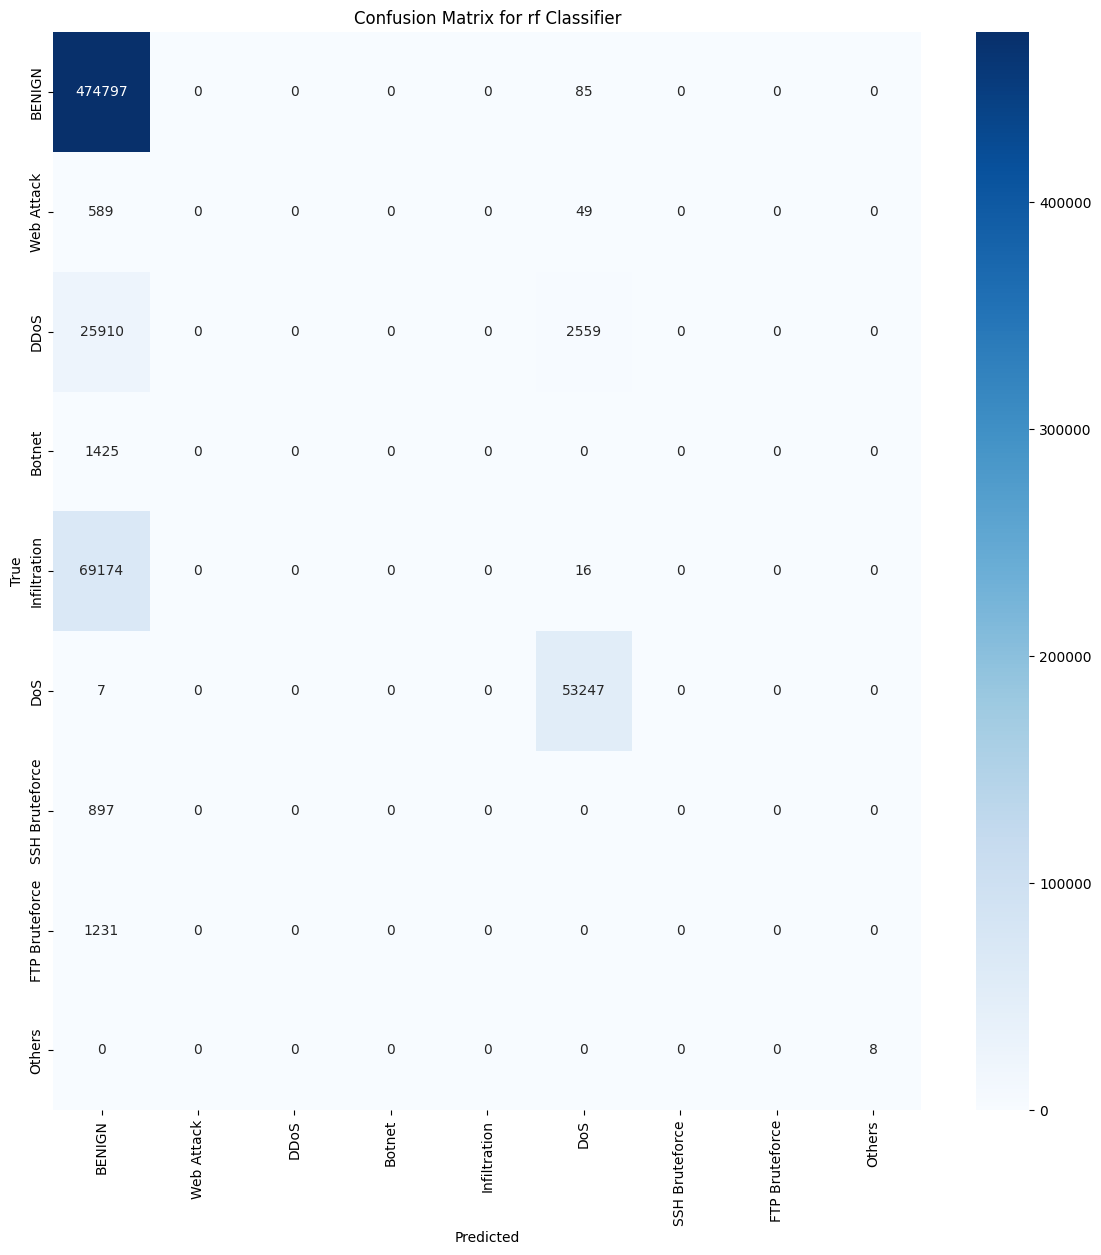

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Src IP', 'Flow ID', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Fwd Packet Length Mean', 'Timestamp', 'Packet Length Max', 'Flow Bytes/s', 'Bwd Segment Size Avg', 'Fwd Seg Size Min', 'Average Packet Size', 'Packet Length Mean', 'Total Length of Bwd Packet', 'Dst Port', 'Fwd Packet Length Max', 'Flow IAT Max', 'Fwd Segment Size Avg', 'Protocol', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'SYN Flag Count', 'Packet Length Std', 'Packet Length Variance', 'Bwd Header Length', 'Fwd Header Length', 'Flow Duration', 'Packet Length Min', 'FWD Init Win Bytes', 'Subflow Bwd Bytes', 'Bwd Packet Length Std']
Initializing RF model top_feature_count = 30


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8382
F1 SCORE: 	 0.3066
PRECISION: 	 0.3135
RECALL: 	 0.3055


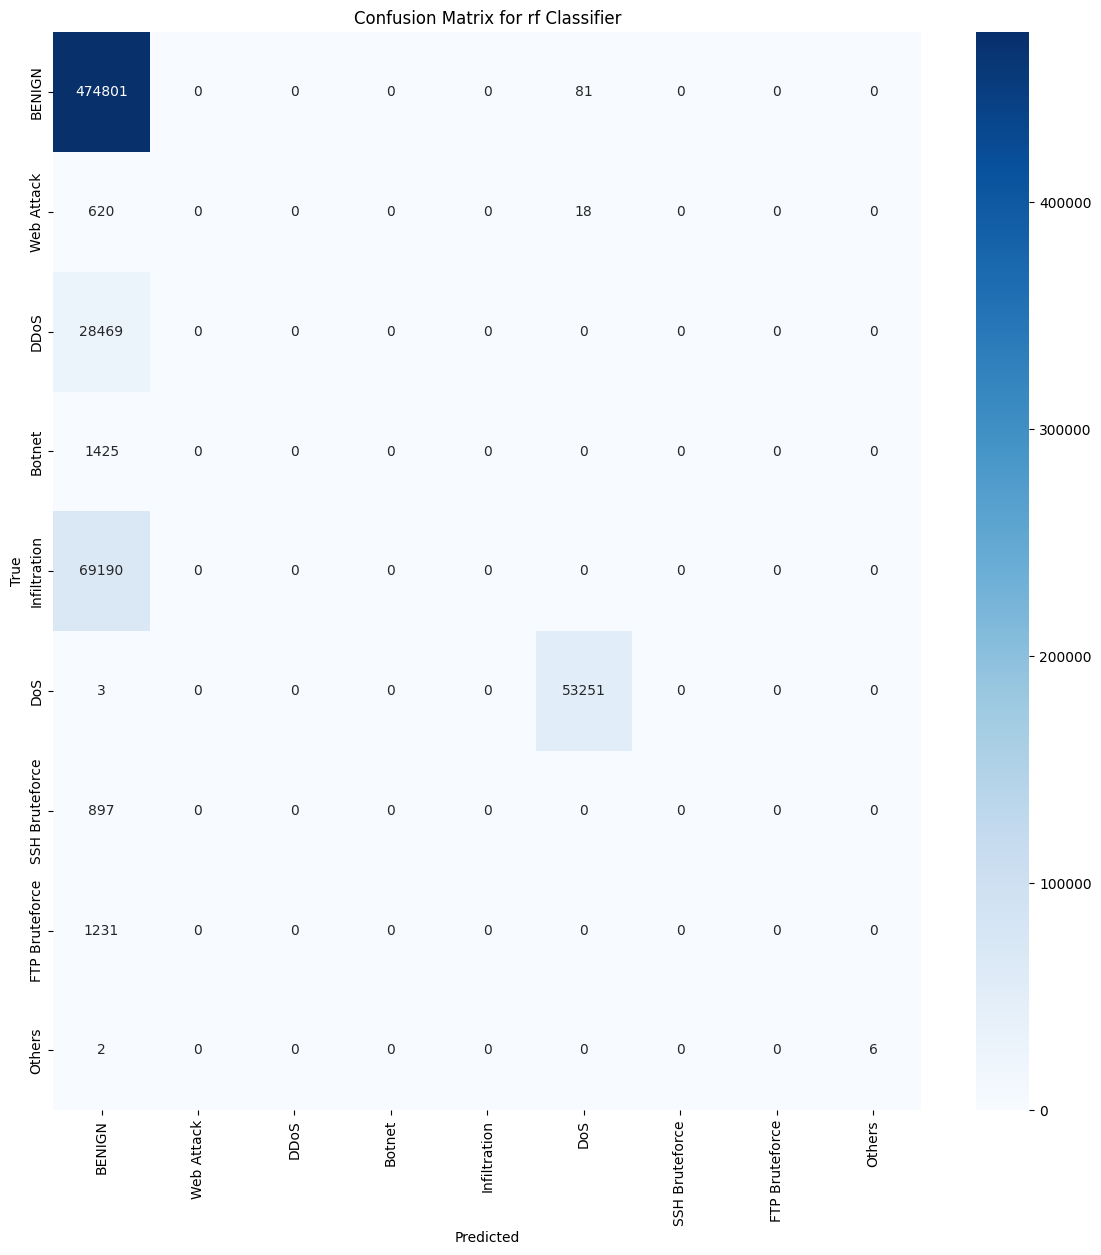

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Src IP', 'Bwd Packet Length Mean', 'Flow ID', 'Bwd Packet Length Max', 'Bwd Segment Size Avg', 'Average Packet Size', 'Packet Length Mean', 'Packet Length Max', 'Flow Bytes/s', 'Fwd Packet Length Max', 'Total Length of Fwd Packet', 'Fwd Packet Length Mean', 'Protocol', 'Timestamp', 'Subflow Bwd Bytes', 'SYN Flag Count', 'Fwd Seg Size Min', 'Packet Length Std', 'Packet Length Variance', 'Total Length of Bwd Packet', 'Dst Port', 'Dst IP', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'FWD Init Win Bytes', 'Bwd Packet Length Min', 'Subflow Fwd Bytes', 'Down/Up Ratio', 'Fwd Act Data Pkts', 'Bwd Header Length', 'Fwd Header Length', 'Total TCP Flow Time', 'Flow Packets/s', 'Fwd IAT Total', 'Bwd IAT Total', 'Flow IAT Std', 'Fwd IAT Std']
Initializing RF model top_feature_count = 40


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8382
F1 SCORE: 	 0.3132
PRECISION: 	 0.3098
RECALL: 	 0.3194


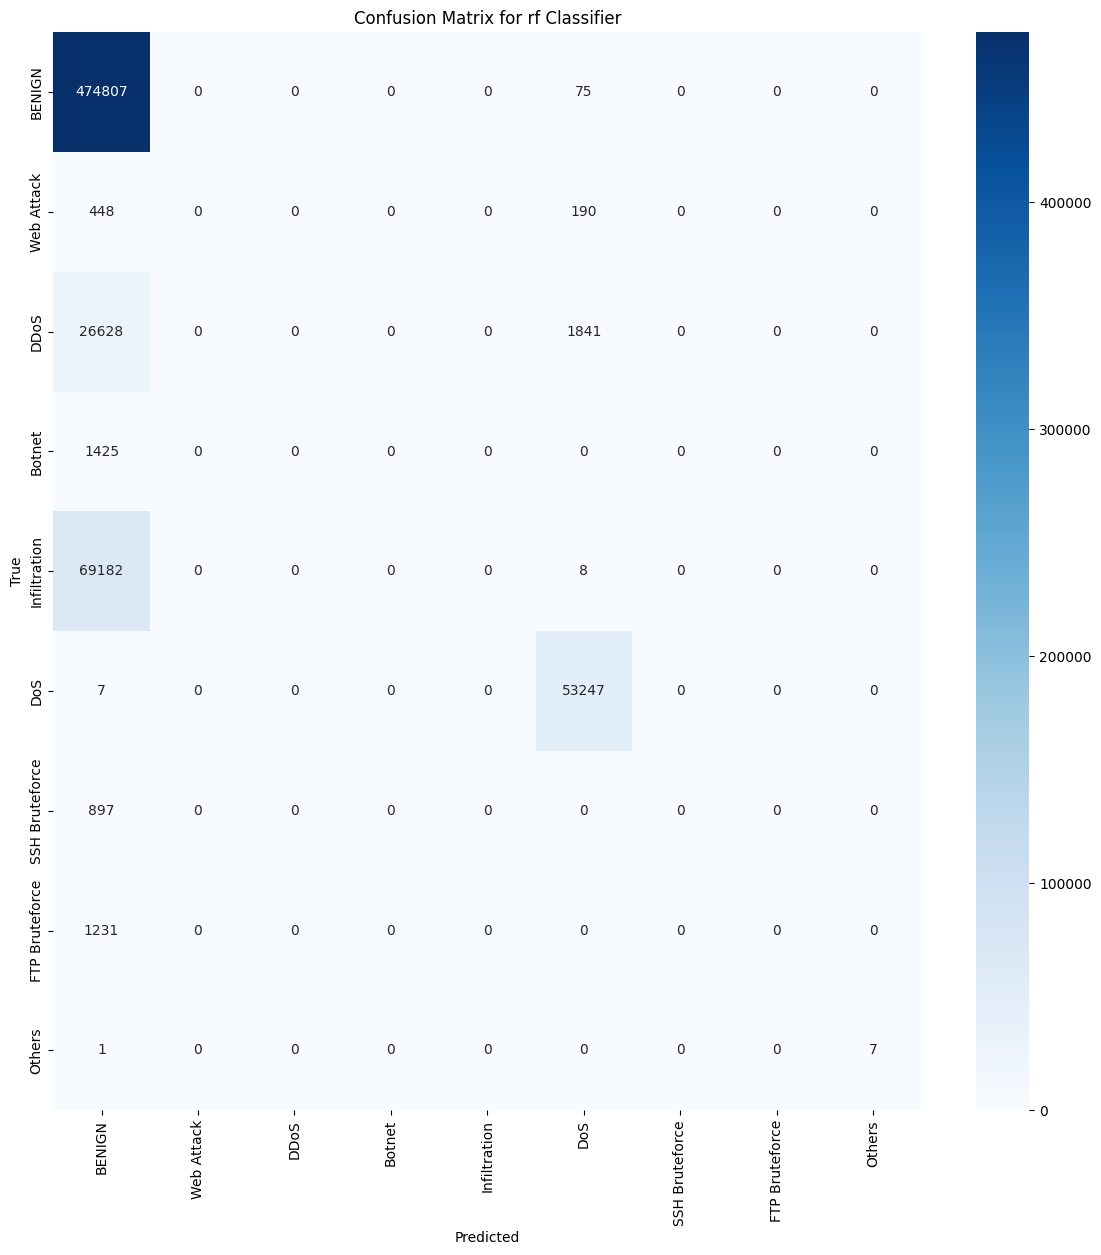

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Src IP', 'Bwd Packet Length Mean', 'Packet Length Mean', 'Flow ID', 'Subflow Bwd Bytes', 'Bwd Packet Length Max', 'Packet Length Max', 'Flow Bytes/s', 'Bwd Segment Size Avg', 'Average Packet Size', 'Fwd Packet Length Max', 'Fwd Packets/s', 'Flow Packets/s', 'Fwd Packet Length Mean', 'Protocol', 'Timestamp', 'Bwd Packet Length Std', 'Packet Length Std', 'Packet Length Variance', 'Total Length of Bwd Packet', 'Dst Port', 'Fwd Packet Length Std', 'Total Length of Fwd Packet', 'Dst IP', 'Bwd IAT Total', 'Bwd Header Length', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd Packets/s', 'Flow IAT Mean', 'Fwd Segment Size Avg', 'Packet Length Min', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'SYN Flag Count', 'Bwd RST Flags', 'RST Flag Count', 'Fwd Seg Size Min', 'Fwd Act Data Pkts', 'Fwd Header Length', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Max', 'Total Bwd packets', 'Fwd IAT Mean', 'Flow IAT Std', 'FWD Init Win Bytes', 'Subflow Fwd Bytes', 'Down/Up Ratio']
Initia

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8382
F1 SCORE: 	 0.3027
PRECISION: 	 0.3059
RECALL: 	 0.3055


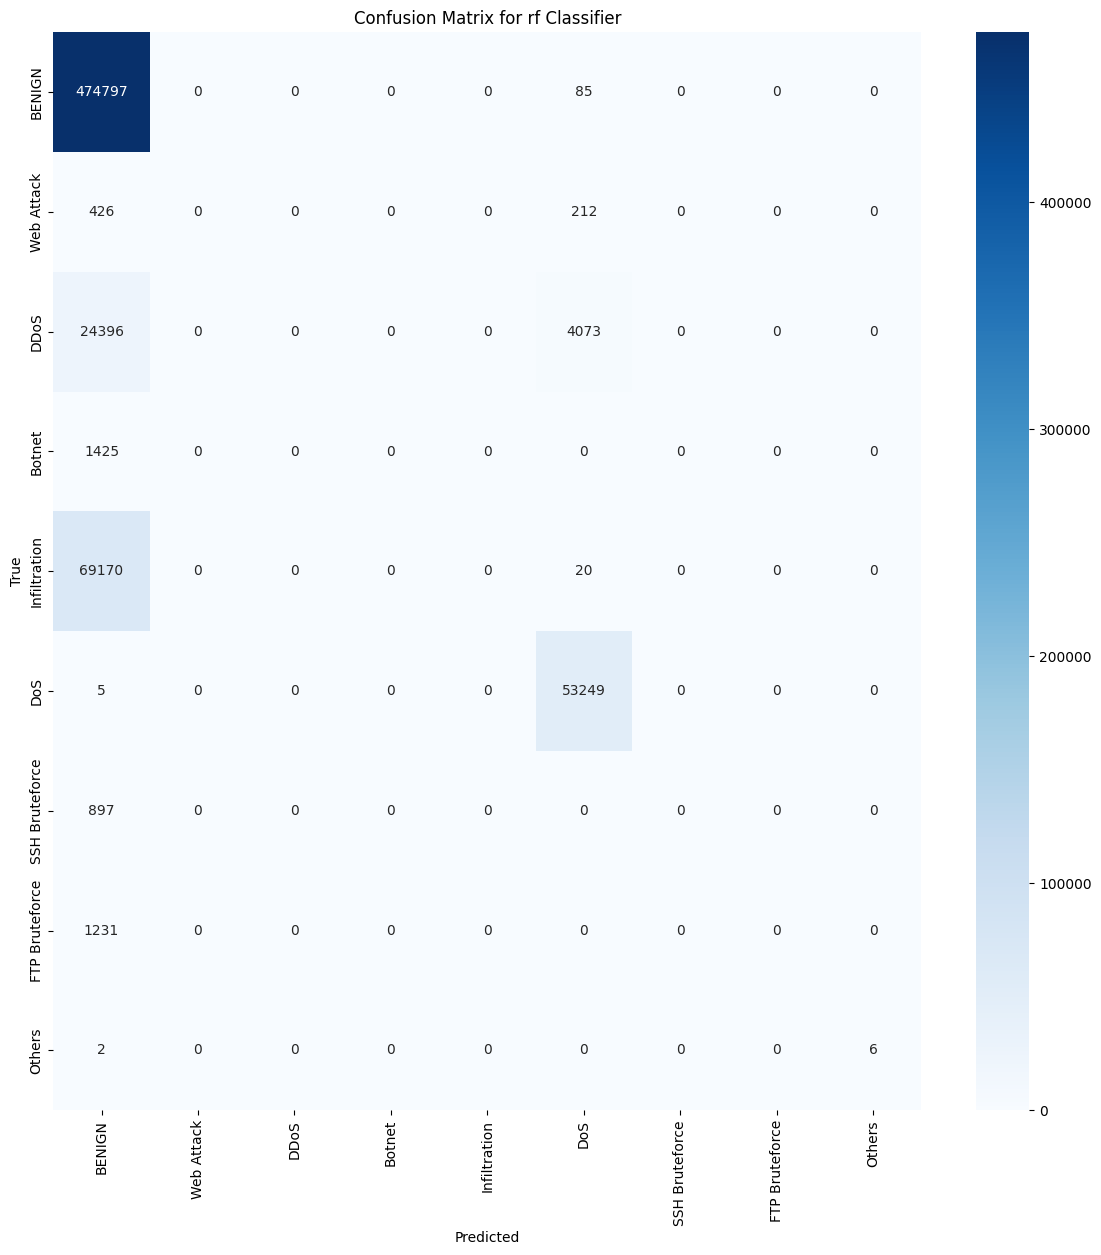

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Src IP', 'Flow ID', 'SYN Flag Count', 'RST Flag Count', 'Bwd Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Packet Length Mean', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Protocol', 'FWD Init Win Bytes', 'Subflow Bwd Bytes', 'Bwd Packet Length Max', 'Packet Length Max', 'Flow Bytes/s', 'Bwd RST Flags', 'Bwd Segment Size Avg', 'Fwd Seg Size Min', 'Average Packet Size', 'Total Length of Bwd Packet', 'Fwd Packet Length Std', 'Down/Up Ratio', 'Total Length of Fwd Packet', 'Fwd Header Length', 'Fwd IAT Std', 'Fwd Packets/s', 'Flow Packets/s', 'Fwd IAT Mean', 'Fwd Packet Length Min', 'Timestamp', 'Bwd Packet Length Std', 'Dst Port', 'Fwd Act Data Pkts', 'Flow IAT Min', 'Dst IP', 'Bwd IAT Total', 'Bwd Header Length', 'PSH Flag Count', 'Bwd IAT Max', 'Bwd PSH Flags', 'Bwd IAT Mean', 'Total Bwd packets', 'Total Fwd Packet', 'ACK Flag Count', 'Flow Duration', 'Bwd Packets/s', 'Flow IAT Mean', 'Fwd IAT Max', 'Flow IAT Std', 'FIN Flag Count', 'Fwd Seg

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8378
F1 SCORE: 	 0.3025
PRECISION: 	 0.3057
RECALL: 	 0.3054


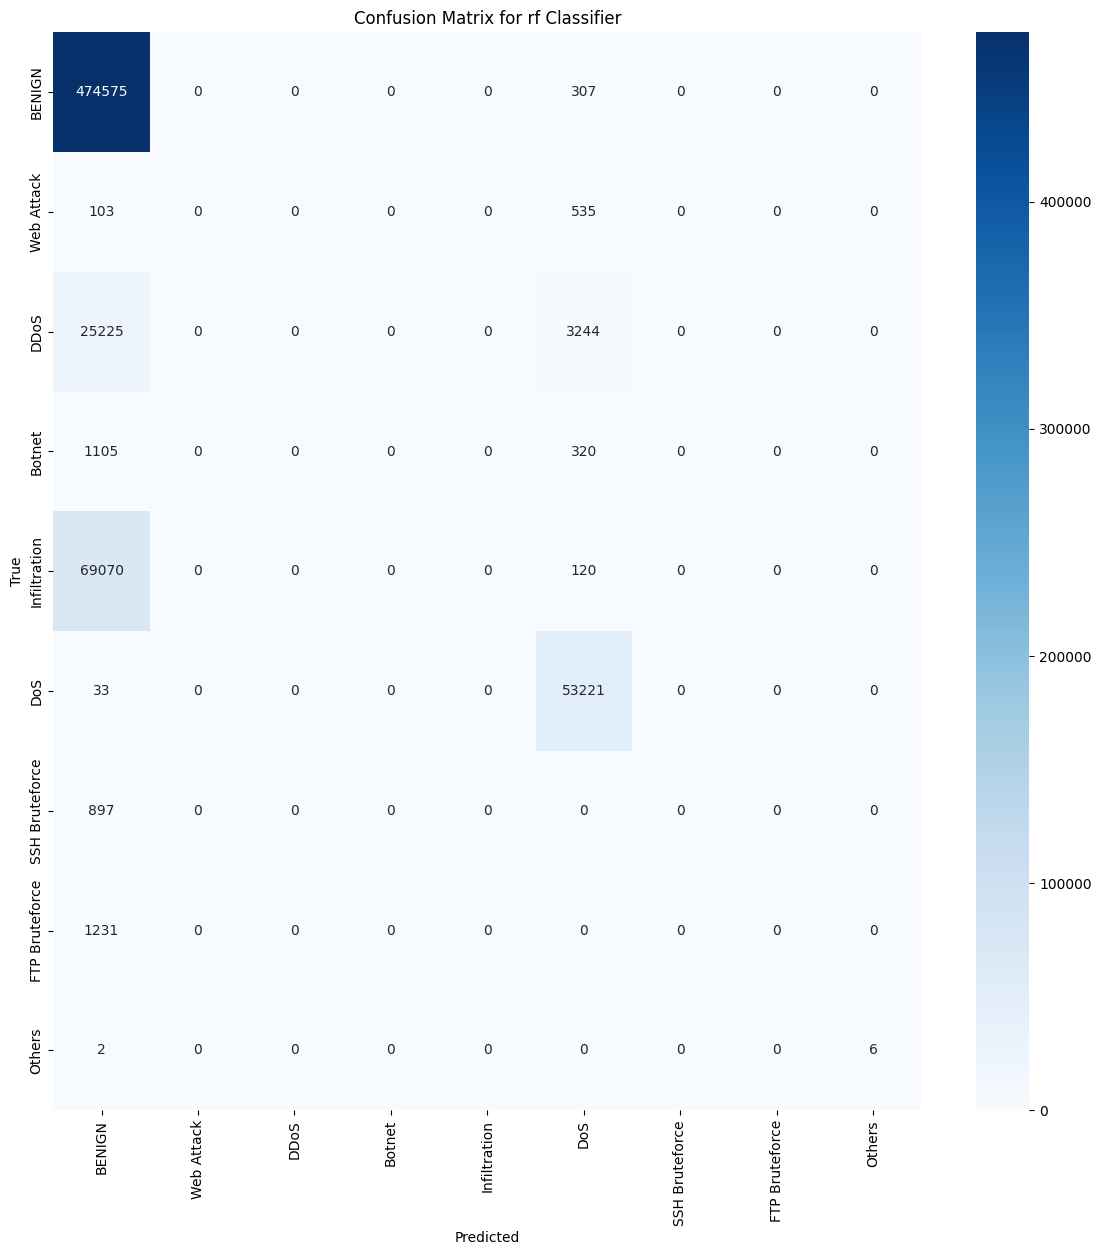

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Src IP', 'Flow ID', 'Protocol', 'Packet Length Min', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'SYN Flag Count', 'Bwd Packet Length Std', 'Bwd Segment Size Avg', 'RST Flag Count', 'Bwd Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Average Packet Size', 'Packet Length Mean', 'Dst Port', 'Fwd Packet Length Std', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Total Length of Fwd Packet', 'Flow IAT Min', 'Fwd IAT Min', 'Dst IP', 'Fwd PSH Flags', 'id', 'Fwd Header Length', 'Fwd IAT Mean', 'Fwd Segment Size Avg', 'Fwd Packet Length Mean', 'Timestamp', 'FWD Init Win Bytes', 'Subflow Bwd Bytes', 'Bwd Packet Length Max', 'Packet Length Max', 'Flow Bytes/s', 'Bwd RST Flags', 'Fwd Seg Size Min', 'Total Length of Bwd Packet', 'Bwd IAT Min', 'Bwd Header Length', 'PSH Flag Count', 'Bwd IAT Mean', 'Total Bwd packets', 'Fwd IAT Std', 'Fwd IAT Max', 'Flow IAT Max', 'Total TCP Flow Time', 'Bwd IAT Std', 'Fwd Packets/s', 'Bwd Packets/s', 'Flow Packets/s', 'FIN Fl

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.8345
F1 SCORE: 	 0.2962
PRECISION: 	 0.2950
RECALL: 	 0.3049


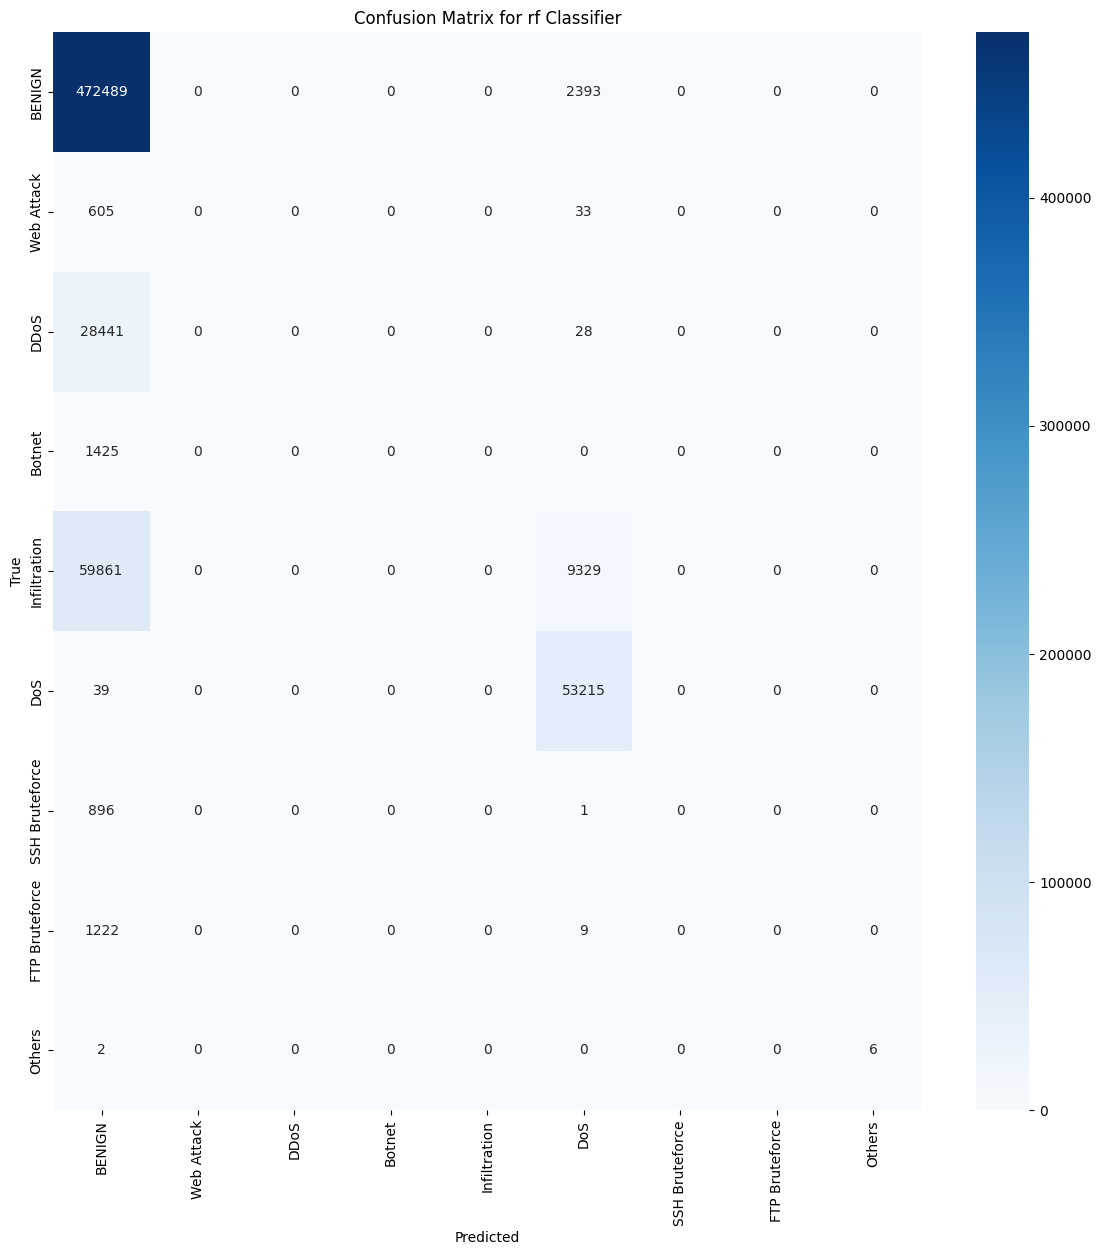

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 1 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 2 done.
File 3 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 4 done.


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


File 5 done.
['Src IP', 'Flow ID', 'Fwd Packet Length Mean', 'Protocol', 'Packet Length Min', 'Fwd Packet Length Min', 'Timestamp', 'FWD Init Win Bytes', 'Bwd Packet Length Min', 'Subflow Bwd Bytes', 'SYN Flag Count', 'Bwd Packet Length Std', 'Packet Length Max', 'Flow Bytes/s', 'Bwd Segment Size Avg', 'RST Flag Count', 'Fwd Seg Size Min', 'Bwd Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Average Packet Size', 'Packet Length Mean', 'Subflow Fwd Bytes', 'Total Length of Bwd Packet', 'Dst Port', 'Fwd Packet Length Std', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Total Length of Fwd Packet', 'Fwd Act Data Pkts', 'Flow IAT Min', 'Fwd RST Flags', 'Active Std', 'Fwd IAT Min', 'Dst IP', 'Bwd IAT Min', 'Active Mean', 'Fwd PSH Flags', 'Bwd Header Length', 'PSH Flag Count', 'Bwd PSH Flags', 'id', 'Fwd Header Length', 'Bwd Bulk Rate Avg', 'Total Bwd packets', 'Fwd IAT Std', 'ACK Flag Count', 'Bwd Packet/Bulk Avg', 'Fwd IAT Max', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Me

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


rf METRICS: 

ACCURACY: 	 0.7534
F1 SCORE: 	 0.1001
PRECISION: 	 0.1339
RECALL: 	 0.1132


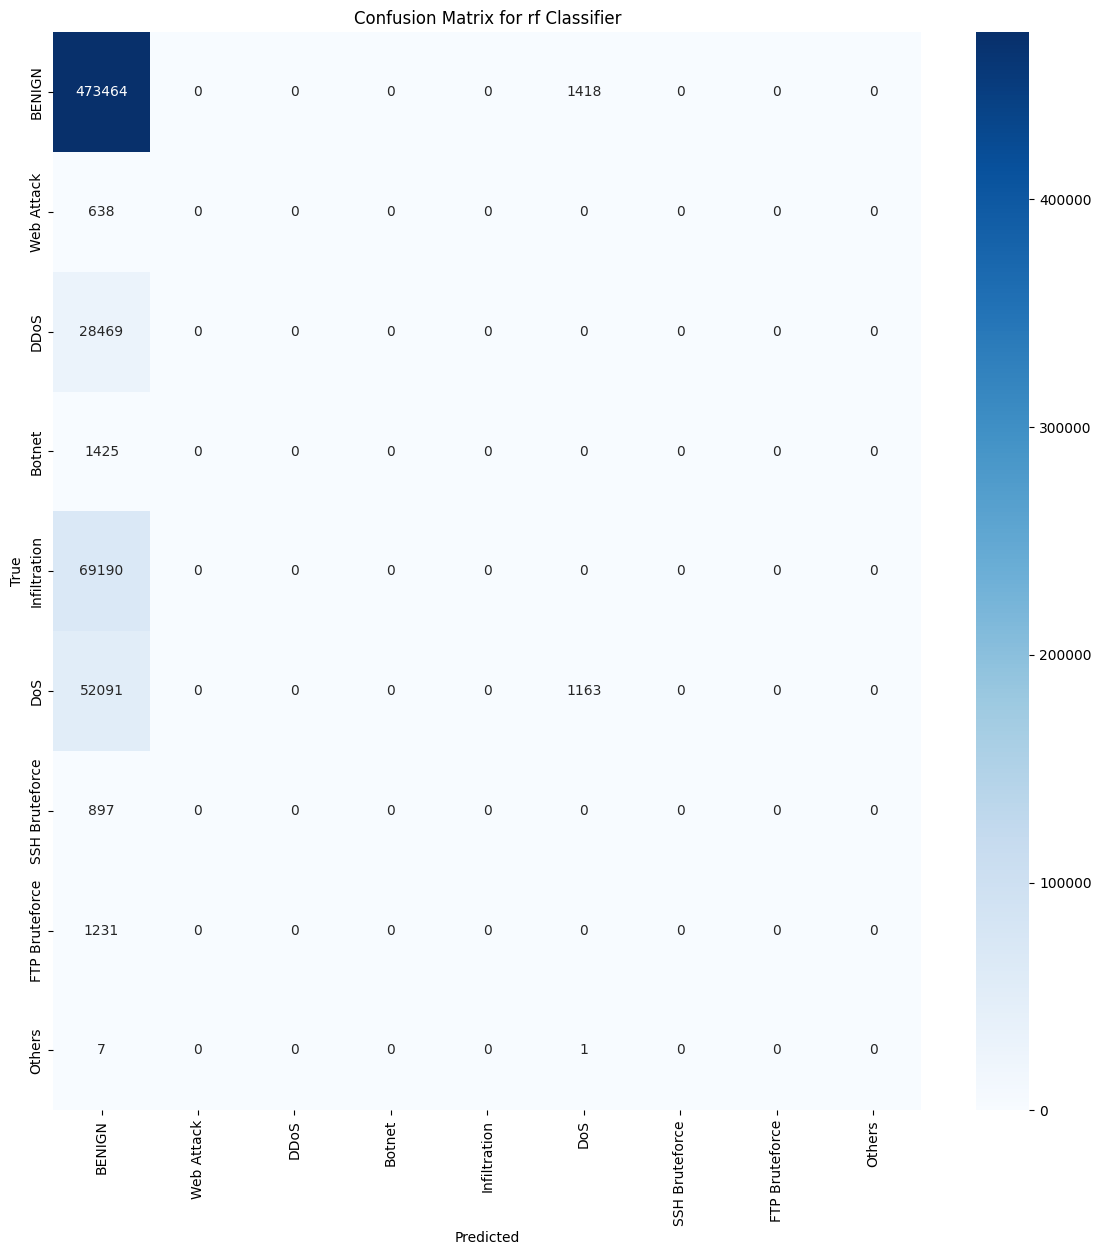

In [ ]:
for k in range(10,90,10):
    top_features = get_top_features_across_files(input_files,'Label',k)
    print(top_features)

    X_test_sets = []
    y_test_sets = []

    # MODELS
    print("Initializing RF model top_feature_count = " + str(k))
    rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

    i = 0

    for f in input_files:
        
        i += 1
            
        #print(f"{i}/{len(input_files)} CURRENT FILE: {f}\n")
        
        df = pd.read_csv(f)
        
        #print(f"LOADED FILE {f}, STARTING CLEANUP\n")
        
        df = dataset_cleaner(df)

        df = remove_selected_features(df,top_features)
        
        #print(f"CLEANUP DONE, STARTING SPLIT\n")
        
        X_train, X_test, y_train, y_test = get_target_features(df, 0.30)
        
        # no need for df now
        df = None
        gc.collect()
        
        X_test.to_csv(f"test_chunks/{i}X_test.csv", index=False)
        y_test.to_csv(f"test_chunks/{i}y_test.csv", index=False)
        
        # no need for the test sets either
        del X_test
        del y_test
        gc.collect()
        
        #print("DONE WRITING TEST SETS TO FILES, STARTING TRAIN\n")
        
        # rf
        #print("RUNNING RF MODEL TRAIN...\n")
        
        rf_model.fit(X_train, y_train)
        
        del X_train
        del y_train
        gc.collect()
        
        #print(f"RF MODEL TRAINED ON FILE: {f} \n\n")
        

    #print(f"{i}/{len(input_files)} files worked on\n\n")

    # clear memory
    df = None
    gc.collect()


    #print("READING X TEST SETS AND PREDICTING\n")
    gc.collect()

    rf_predictions = []
    y_tests = []

    for curr in range(1,i+1):
        #print(f"Reading X_test file {curr}/{i}\n")

        df_X = pd.read_csv(f"test_chunks/{curr}X_test.csv")
        
        #print(f"Read {curr}-th X_test file, shape: {df_X.shape}\nPredicting and appending...")
        
        pred = rf_model.predict(df_X)
        rf_predictions.append(pred)
        
        del df_X 
        gc.collect()
        
        #print(f"Done reading and predictiong on X_test file {curr}/{i}\n")
        

    rf_predictions_joined = np.concatenate(rf_predictions)

    # remove prediction list
    del rf_predictions
    gc.collect()

    #print("PREDICTION DONE USING RF MODELS: ")
    #print( rf_predictions_joined.shape)

    #print("\nREADING y_test FILES\n")

    for curr in range(1,i+1):
        #print(f"Reading y_test file {curr}/{i}\n")

        df_y = pd.read_csv(f"test_chunks/{curr}y_test.csv")
        
        #print(f"Read {curr}-th y_test file, shape: {df_y.shape}\nAppending...")
        
        y_tests.append(df_y)
        
        del df_y
        gc.collect()
        
        #print(f"Done reading and adding y_test file {curr}/{i}\n")
        
    y_test_sets_joined = pd.concat(y_tests)

    # remove y_tests
    del y_tests
    gc.collect()


    #print("DONE READING y_test FILES: ")
    #print(y_test_sets_joined.shape)



    rf_accuracy = accuracy_score(y_test_sets_joined, rf_predictions_joined)
    rf_f1 = f1_score(y_test_sets_joined, rf_predictions_joined, average='macro')
    rf_precision = precision_score(y_test_sets_joined, rf_predictions_joined, average='macro')
    rf_recall = recall_score(y_test_sets_joined, rf_predictions_joined, average='macro')

    print("\n rf METRICS: \n")
    print(f"ACCURACY: \t {rf_accuracy:.4f}")
    print(f"F1 SCORE: \t {rf_f1:.4f}")
    print(f"PRECISION: \t {rf_precision:.4f}")
    print(f"RECALL: \t {rf_recall:.4f}")
    classes = ["BENIGN", "Web Attack", "DDoS", "Botnet", "Infiltration", "DoS", "SSH Bruteforce", "FTP Bruteforce", "Others"]
    title = "Confusion Matrix for rf Classifier"

    cm = confusion_matrix(y_test_sets_joined, rf_predictions_joined)
    plt.figure(figsize=(14, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    f = open("results.txt", "a")
    f.write("Initializing RF model top_feature_count = " + str(i))
    f.write("rf METRICS: \n")
    f.write(f"ACCURACY: \t {rf_accuracy:.4f}")
    f.write(f"F1 SCORE: \t {rf_f1:.4f}")
    f.write(f"PRECISION: \t {rf_precision:.4f}")
    f.write(f"RECALL: \t {rf_recall:.4f}")
    f.close()
        